In [1]:
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import myutils
import ssd_utils
import importlib
import gluoncv as gcv
import ssd_utils_test

In [2]:
backbone_root_path = 'd:/Documents/Data_Files/Parameters/'
ctx = mx.gpu()
ssd = ssd_utils.SSD2(backbone_root_path, ctx=ctx)
ssd.hybridize()

root_path = 'd:/Documents/Data_Files/Datasets/Pascal/VOC2012/'
dataset = myutils.Dataset(root_path)
dataset_val = myutils.Dataset(root_path, mode='val')
print('dataset num:', len(dataset))

batch_size = 10
dataloader = mx.gluon.data.DataLoader(dataset.transform(ssd.get_transform_fn()), batch_size, shuffle=True, batchify_fn=myutils.batchify_fn)

batch_size_val = 4
dataloader_val = mx.gluon.data.DataLoader(dataset_val.transform(ssd.get_transform_fn_val()), 
                                          batch_size=batch_size_val, shuffle=False, last_batch='keep',
                                          batchify_fn=myutils.batchify_fn_val_2)

anchors = mx.nd.array(ssd.get_anchors(), ctx=ssd.ctx)
anchors = anchors.expand_dims(axis=0)  # (1, N, 4)

dataset num: 5717


In [3]:
# define trainer
trainer = mx.gluon.Trainer(ssd.collect_params(), 'sgd', {'wd': 0.0005, 'momentum':0.9})
tarin_epoch = 30
initial_lr = 0.005
trainer.set_learning_rate(initial_lr)
lr_scheduler = mx.lr_scheduler.PolyScheduler(tarin_epoch, initial_lr)

In [4]:
def calc_val_ap(net, dataloader_val):
    metric = ssd_utils.SSDMetric2(dataset_val.class_names, ssd.get_anchors())
    metric.reset()
    for mx_imgs, mx_labels, img_sizes in dataloader_val:
        tensor_preds = net(mx_imgs.as_in_context(ssd.ctx))
        metric.update(tensor_preds, mx_imgs, mx_labels, img_sizes)
    return metric.get()[1][-1]

## 增加 class probability 的 threshold 后的实验：

In [139]:
with open('serial_arch_aps', 'wb') as f:
    pickle.dump(aps, f)

In [5]:
importlib.reload(ssd_utils)
epoch_losses = []
aps = []
for epoch in range(tarin_epoch):
    epoch_loss = 0
    for i, (mx_imgs, mx_labels) in enumerate(dataloader):
        mx_labels = mx_labels.as_in_context(ssd.ctx)
        
        with mx.autograd.record():
            tensor_preds = ssd(mx_imgs.as_in_context(ssd.ctx))
            tensor_targs = ssd_utils.generate_target2(anchors, tensor_preds, mx_labels, 
                                          iou_thresh=0.5, neg_thresh=0.5, negative_mining_ratio=3, dynamic_sampling=True)
            sum_loss, _, _, _ = ssd_utils.calc_loss2(tensor_preds, epoch, *tensor_targs)   
        if i % 100 == 0:
            ssd_utils_test.test_preds(mx_imgs, mx_labels, ssd, tensor_targs)
            ssd_utils_test.test_calc_loss2(mx_imgs, mx_labels, ssd, epoch)
        sum_loss.backward()
        trainer.step(1)
        trainer.set_learning_rate(lr_scheduler(epoch))
        epoch_loss += sum(sum_loss).mean().asscalar()
    aps.append(calc_val_ap(ssd, dataloader_val))
    epoch_losses.append(epoch_loss)
    print('epoch %d, loss: %.4f, ap: %.4f' % (epoch, epoch_loss, aps[-1]))

mean: pos pre: 0.0110, pos rec: 0.5543, neg pre: 0.9934, neg rec: 0.6096, hard neg rec: 0.4294, cls rec: 0.0681 box pre: 0.0030
loss sum: 11.700123 confidence loss: 1.3511674 class probability loss: 3.1962283 box regression loss: 7.152727
mean: pos pre: 0.2828, pos rec: 0.2975, neg pre: 0.9924, neg rec: 0.9947, hard neg rec: 0.9649, cls rec: 0.4719 box pre: 0.1920
loss sum: 7.649952 confidence loss: 0.56986636 class probability loss: 2.0572178 box regression loss: 5.0228677
mean: pos pre: 0.4867, pos rec: 0.5399, neg pre: 0.9958, neg rec: 0.9974, hard neg rec: 0.9492, cls rec: 0.4880 box pre: 0.4923
loss sum: 4.8380003 confidence loss: 0.47208697 class probability loss: 1.1693901 box regression loss: 3.1965232
mean: pos pre: 0.2628, pos rec: 0.3974, neg pre: 0.9946, neg rec: 0.9926, hard neg rec: 0.9557, cls rec: 0.5591 box pre: 0.2394
loss sum: 6.441842 confidence loss: 0.54979104 class probability loss: 1.4923524 box regression loss: 4.3996987
mean: pos pre: 0.3797, pos rec: 0.5422, 

mean: pos pre: 0.5074, pos rec: 0.4756, neg pre: 0.9963, neg rec: 0.9979, hard neg rec: 0.9673, cls rec: 0.7950 box pre: 0.4537
loss sum: 3.3970966 confidence loss: 0.42404425 class probability loss: 0.6584145 box regression loss: 2.4635837
mean: pos pre: 0.6085, pos rec: 0.5343, neg pre: 0.9931, neg rec: 0.9964, hard neg rec: 0.9669, cls rec: 0.7934 box pre: 0.4956
loss sum: 4.8133974 confidence loss: 0.461917 class probability loss: 0.88943684 box regression loss: 3.663251
mean: pos pre: 0.5614, pos rec: 0.5542, neg pre: 0.9956, neg rec: 0.9975, hard neg rec: 0.9727, cls rec: 0.7547 box pre: 0.5046
loss sum: 3.6943078 confidence loss: 0.40652555 class probability loss: 0.9698513 box regression loss: 2.53733
epoch 5, loss: 1981.2220, ap: 0.4782
mean: pos pre: 0.6436, pos rec: 0.7078, neg pre: 0.9981, neg rec: 0.9985, hard neg rec: 0.9735, cls rec: 0.7894 box pre: 0.7156
loss sum: 2.8721995 confidence loss: 0.36473423 class probability loss: 0.7903096 box regression loss: 1.9265151
mea

mean: pos pre: 0.7549, pos rec: 0.6236, neg pre: 0.9961, neg rec: 0.9988, hard neg rec: 0.9674, cls rec: 0.9213 box pre: 0.7709
loss sum: 2.6310883 confidence loss: 0.39130682 class probability loss: 0.4307842 box regression loss: 1.9947513
mean: pos pre: 0.6942, pos rec: 0.6702, neg pre: 0.9978, neg rec: 0.9987, hard neg rec: 0.9530, cls rec: 0.9350 box pre: 0.7926
loss sum: 2.000116 confidence loss: 0.38671145 class probability loss: 0.34795186 box regression loss: 1.4154897
mean: pos pre: 0.7050, pos rec: 0.6086, neg pre: 0.9953, neg rec: 0.9978, hard neg rec: 0.9727, cls rec: 0.9204 box pre: 0.5184
loss sum: 2.8368924 confidence loss: 0.39077568 class probability loss: 0.45098558 box regression loss: 2.1895962
mean: pos pre: 0.7099, pos rec: 0.7356, neg pre: 0.9987, neg rec: 0.9986, hard neg rec: 0.9627, cls rec: 0.9494 box pre: 0.7487
loss sum: 1.2795705 confidence loss: 0.31429815 class probability loss: 0.25980073 box regression loss: 0.8174976
mean: pos pre: 0.7785, pos rec: 0.

mean: pos pre: 0.8519, pos rec: 0.6239, neg pre: 0.9957, neg rec: 0.9987, hard neg rec: 0.9663, cls rec: 0.8942 box pre: 0.6097
loss sum: 1.6055295 confidence loss: 0.33577785 class probability loss: 0.4204891 box regression loss: 1.0846832
mean: pos pre: 0.7939, pos rec: 0.6221, neg pre: 0.9939, neg rec: 0.9983, hard neg rec: 0.9690, cls rec: 0.8653 box pre: 0.6496
loss sum: 2.1394665 confidence loss: 0.39289275 class probability loss: 0.53702205 box regression loss: 1.5102161
mean: pos pre: 0.9051, pos rec: 0.7901, neg pre: 0.9984, neg rec: 0.9996, hard neg rec: 0.9788, cls rec: 0.9223 box pre: 0.8758
loss sum: 0.98675394 confidence loss: 0.28097445 class probability loss: 0.32952306 box regression loss: 0.5607476
epoch 16, loss: 972.9621, ap: 0.5217
mean: pos pre: 0.7977, pos rec: 0.6860, neg pre: 0.9979, neg rec: 0.9991, hard neg rec: 0.9562, cls rec: 0.9058 box pre: 0.6051
loss sum: 1.2218976 confidence loss: 0.3231981 class probability loss: 0.34824762 box regression loss: 0.7530

mean: pos pre: 0.8348, pos rec: 0.7458, neg pre: 0.9980, neg rec: 0.9989, hard neg rec: 0.9688, cls rec: 0.9575 box pre: 0.6345
loss sum: 0.9279634 confidence loss: 0.28855795 class probability loss: 0.21896607 box regression loss: 0.56856257
mean: pos pre: 0.8647, pos rec: 0.5326, neg pre: 0.9928, neg rec: 0.9991, hard neg rec: 0.9793, cls rec: 0.9194 box pre: 0.5752
loss sum: 2.2472098 confidence loss: 0.37098292 class probability loss: 0.45219988 box regression loss: 1.729925
mean: pos pre: 0.8559, pos rec: 0.7717, neg pre: 0.9974, neg rec: 0.9990, hard neg rec: 0.9816, cls rec: 0.9370 box pre: 0.8216
loss sum: 2.7784495 confidence loss: 0.32785845 class probability loss: 0.38054332 box regression loss: 2.3274724
mean: pos pre: 0.8002, pos rec: 0.7635, neg pre: 0.9985, neg rec: 0.9991, hard neg rec: 0.9565, cls rec: 0.9736 box pre: 0.7580
loss sum: 0.76580364 confidence loss: 0.28212002 class probability loss: 0.2187199 box regression loss: 0.41292042
mean: pos pre: 0.7945, pos rec:

KeyboardInterrupt: 

In [106]:
mx_imgs, mx_labels = next(iter(dataloader))

In [112]:
scores_cls_boxes[i, :20, -4:].asnumpy()[:, 0] >= 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False])

[[11.          0.03174603  0.08056872  0.829932    1.        ]]


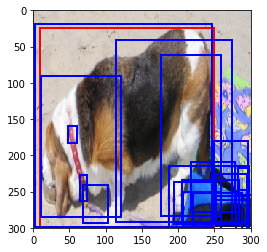


[[ 9.97563243e-01  1.10000000e+01  6.90743327e-03  6.10167980e-02
   8.21924806e-01  9.97524738e-01]
 [ 1.54042751e-01  1.10000000e+01  3.78589332e-01  1.37798965e-01
   9.13362920e-01  9.71225798e-01]
 [ 5.63661866e-02  1.10000000e+01  5.90032816e-01  2.06390232e-01
   8.64921927e-01  9.47723389e-01]
 [ 4.70029376e-02  1.40000000e+01  6.24294400e-01  7.15205550e-01
   9.90930796e-01  1.01605785e+00]
 [ 3.89819145e-02  1.40000000e+01  6.83432579e-01  7.80073643e-01
   9.48671341e-01  9.81598377e-01]
 [ 3.75509337e-02  1.10000000e+01  3.68436575e-02  3.02109152e-01
   4.03575122e-01  9.48339820e-01]
 [ 2.54227985e-02  1.40000000e+01  7.23480344e-01  6.96630836e-01
   9.30324674e-01  9.29002285e-01]
 [ 2.34505367e-02  1.40000000e+01  9.32129860e-01  8.50469410e-01
   1.01821363e+00  1.03054500e+00]
 [ 1.90525427e-02  1.40000000e+01  7.35152662e-01  8.39389861e-01
   9.61241186e-01  1.01226199e+00]
 [ 1.27482535e-02  4.00000000e+00  9.44079280e-01  7.25126326e-01
   9.88235593e-01  8.281

In [118]:

importlib.reload(ssd_utils)
tensor_preds = ssd(mx_imgs.as_in_context(ssd.ctx))
scores_cls_boxes = ssd_utils.get_pred_scores_cls_boxes2(tensor_preds, None, anchors, is_sorted=True)

i = 5
print(mx_labels[i].asnumpy()[mx_labels[i].asnumpy()[:, 0] >= 0])
plt.imshow(myutils.denormalize(mx_imgs[i].transpose((1, 2, 0)).asnumpy()))
myutils.visualize_boxes(mx_labels[i, :, 1:].asnumpy(), 'red', fig=plt.gcf(), is_rltv_cor=True, img_size=[300, 300])
myutils.visualize_boxes(scores_cls_boxes[i, :20, -4:].asnumpy()[scores_cls_boxes[i, :20, -4:].asnumpy()[:, 0] >= 0], 'blue', fig=plt.gcf(), is_rltv_cor=True, img_size=[300, 300])
if not plt.gca().yaxis_inverted():
    plt.gca().invert_yaxis() 
plt.show()

print(scores_cls_boxes[i, :20])

In [134]:
mx_labels.shape

(10, 10, 5)

(90, 10)
900
(90, 10)
900
(270, 10)
2700
(900, 10)
9000
(450, 10)
4500
(90, 10)
900
(180, 10)
1800
(90, 10)
900
(180, 10)
1800
(180, 10)
1800
img 0: positives: 30.0, negatives: 90.0


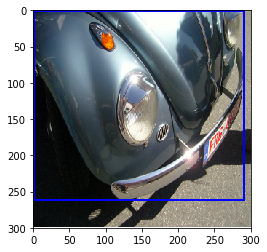

positive samples on each feature map:
anchor index: 0


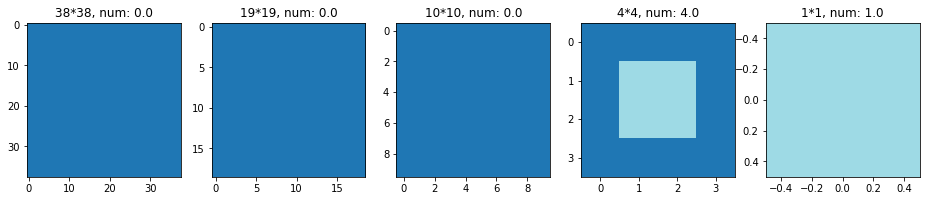

anchor index: 1


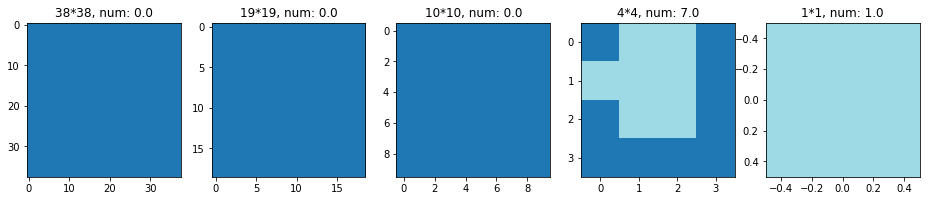

anchor index: 2


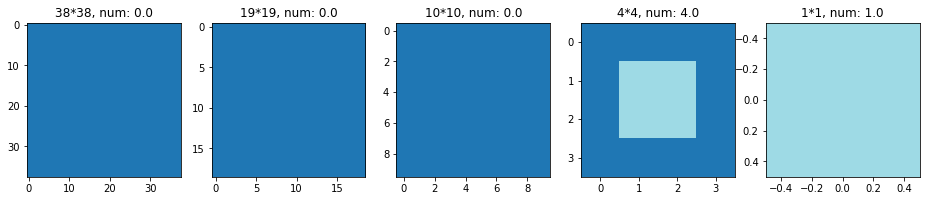

anchor index: 3


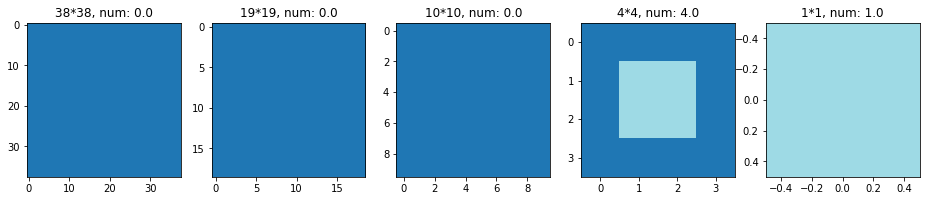

anchor index: 4


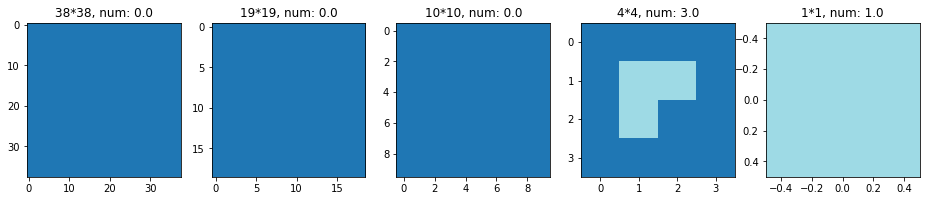

anchor index: 5


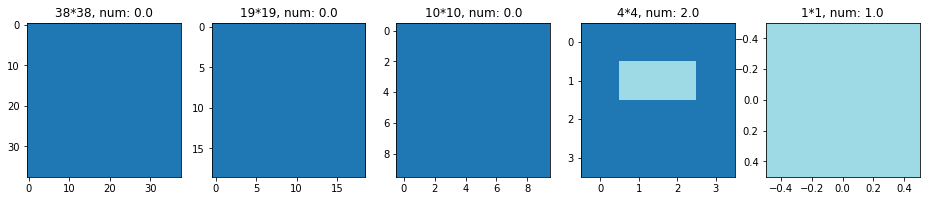

negative samples on each feature map:
anchor index: 0


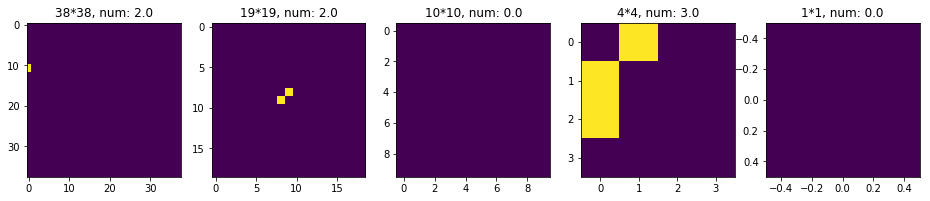

anchor index: 1


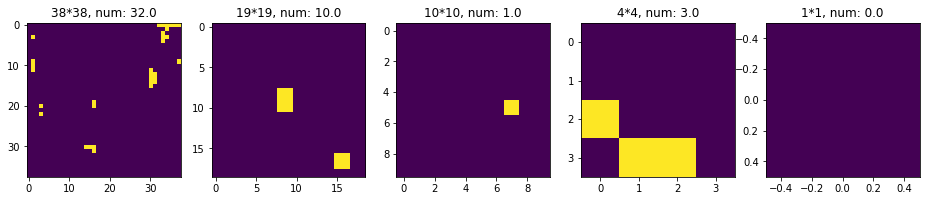

anchor index: 2


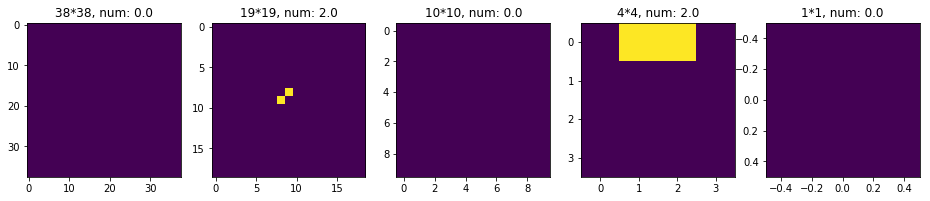

anchor index: 3


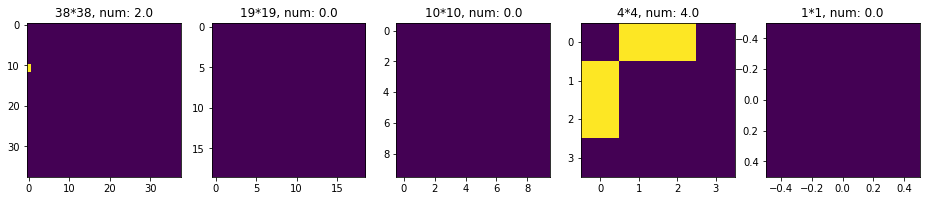

anchor index: 4


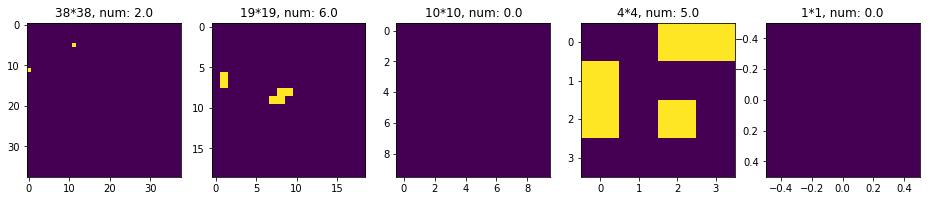

anchor index: 5


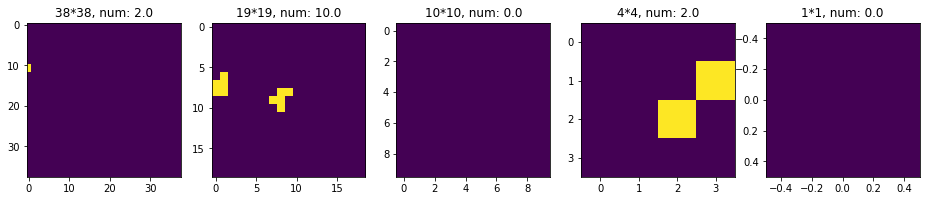

img 1: positives: 30.0, negatives: 90.0


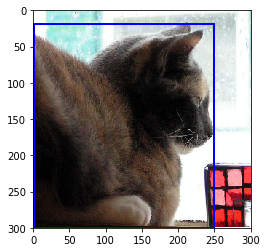

positive samples on each feature map:
anchor index: 0


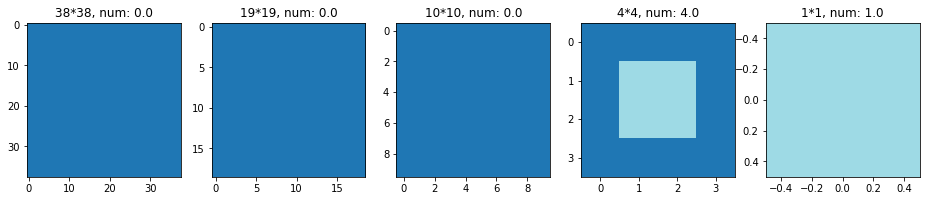

anchor index: 1


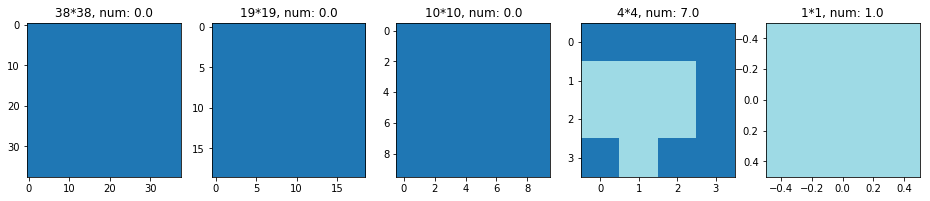

anchor index: 2


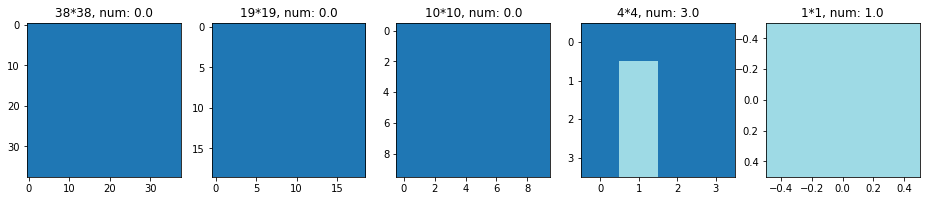

anchor index: 3


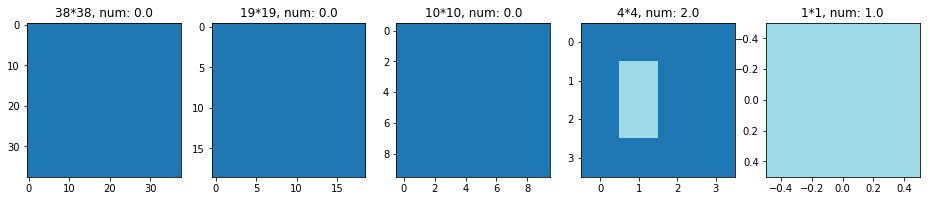

anchor index: 4


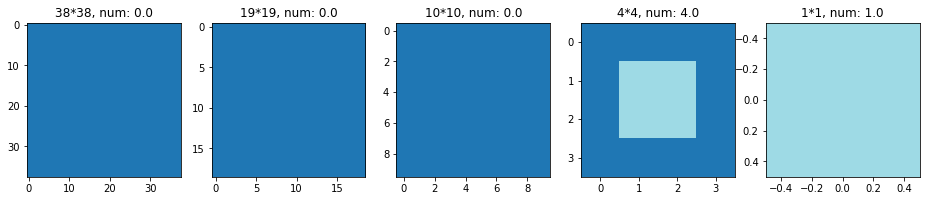

anchor index: 5


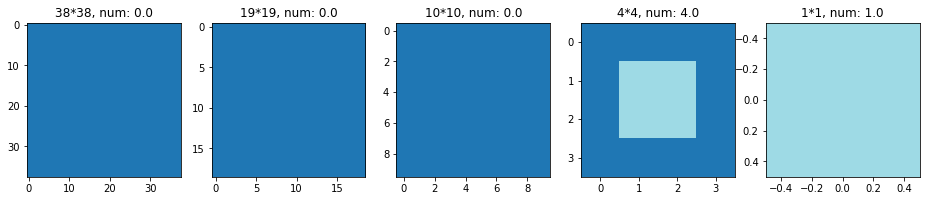

negative samples on each feature map:
anchor index: 0


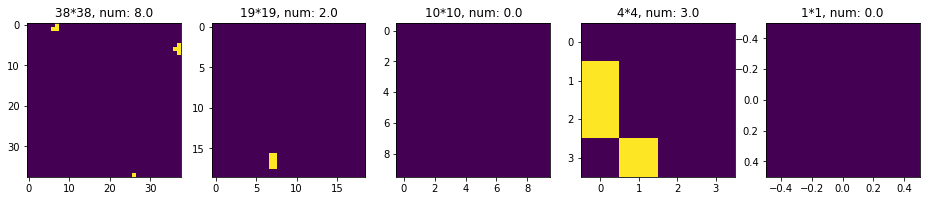

anchor index: 1


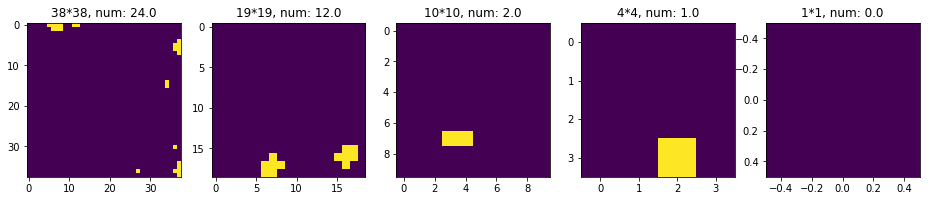

anchor index: 2


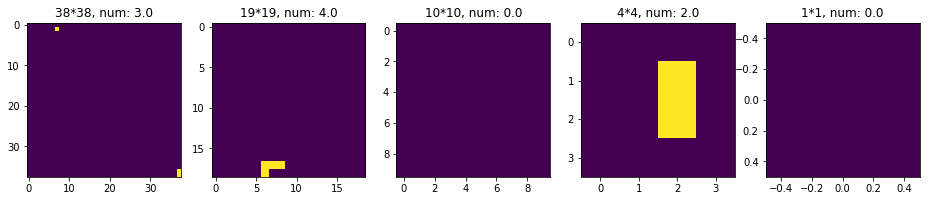

anchor index: 3


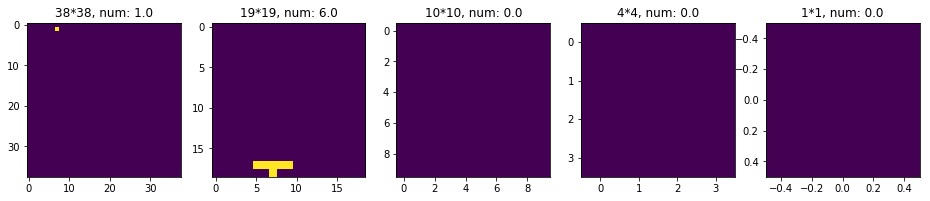

anchor index: 4


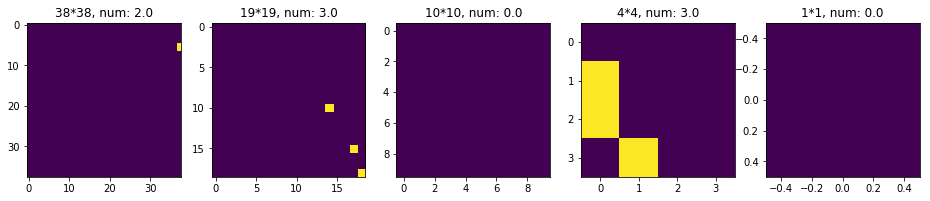

anchor index: 5


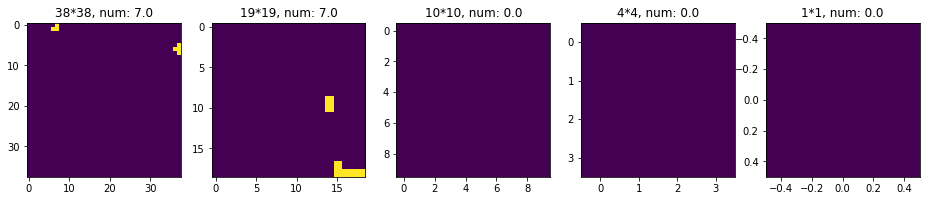

img 2: positives: 90.0, negatives: 270.0


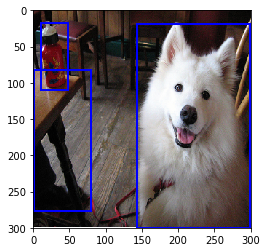

positive samples on each feature map:
anchor index: 0


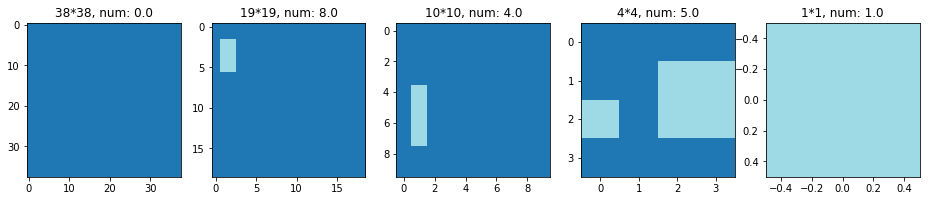

anchor index: 1


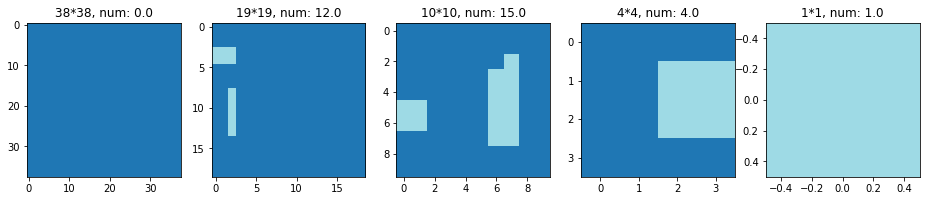

anchor index: 2


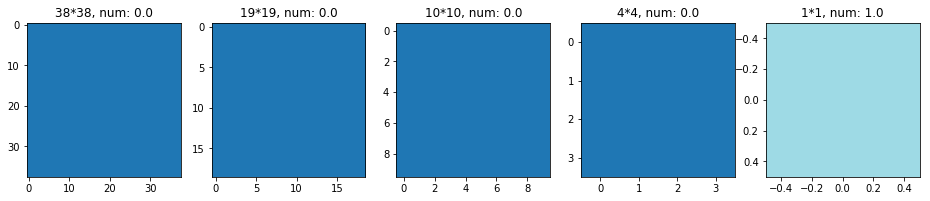

anchor index: 3


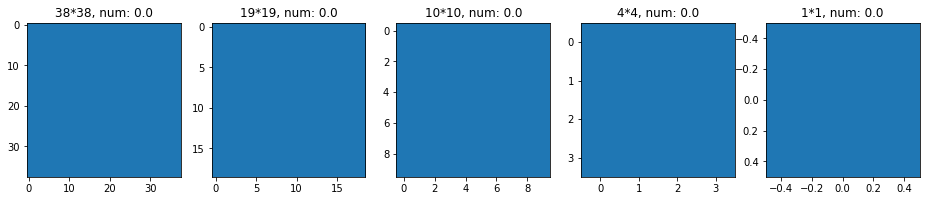

anchor index: 4


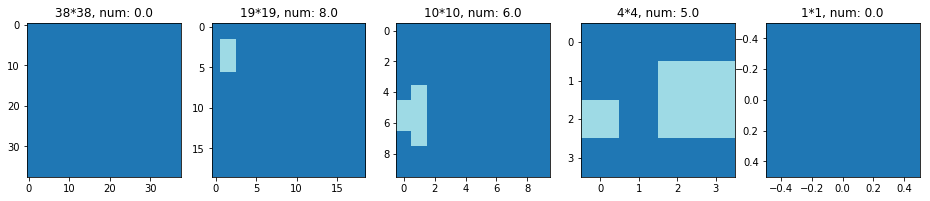

anchor index: 5


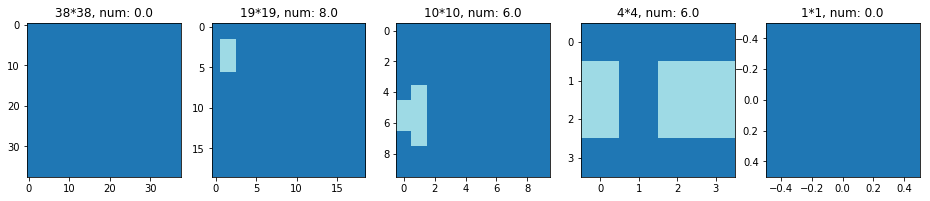

negative samples on each feature map:
anchor index: 0


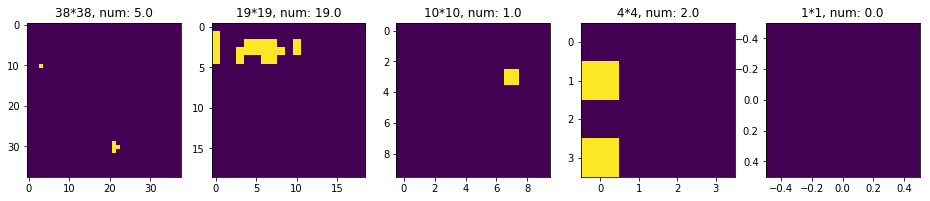

anchor index: 1


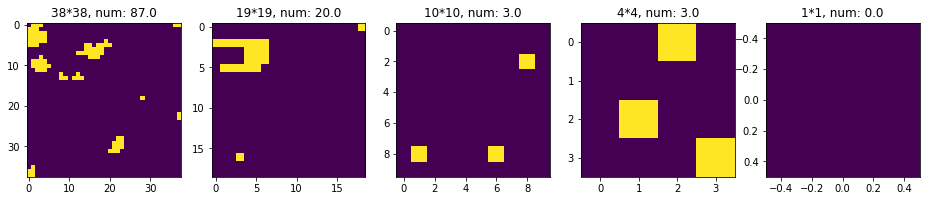

anchor index: 2


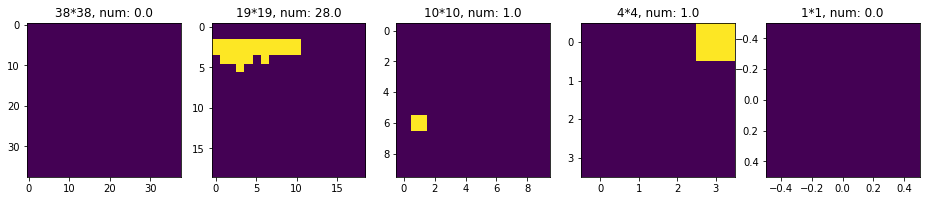

anchor index: 3


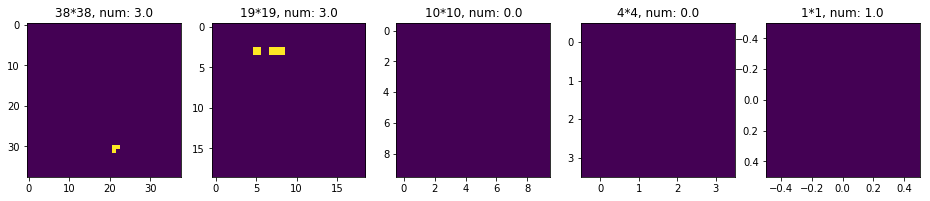

anchor index: 4


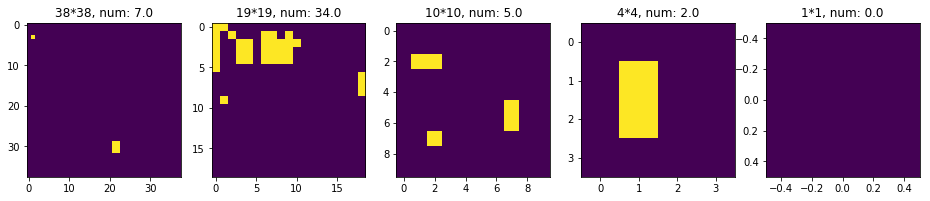

anchor index: 5


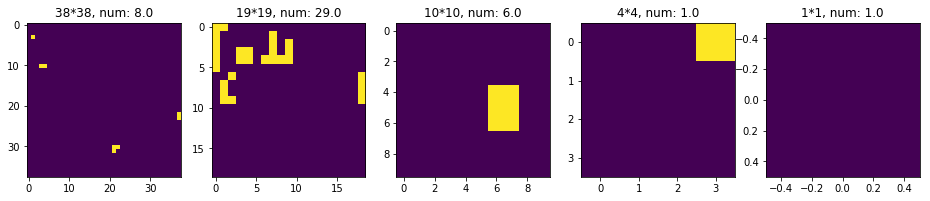

img 3: positives: 300.0, negatives: 900.0


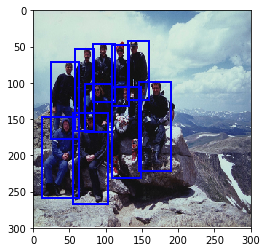

positive samples on each feature map:
anchor index: 0


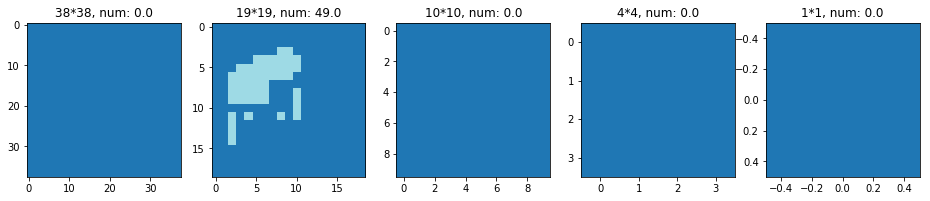

anchor index: 1


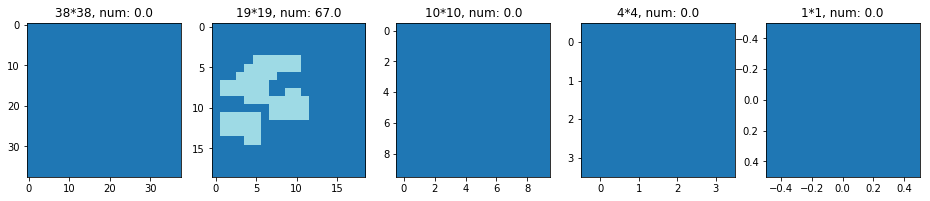

anchor index: 2


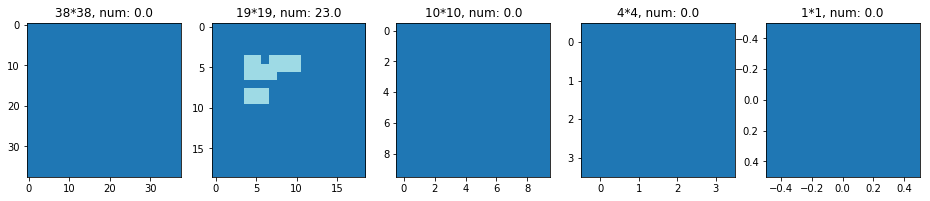

anchor index: 3


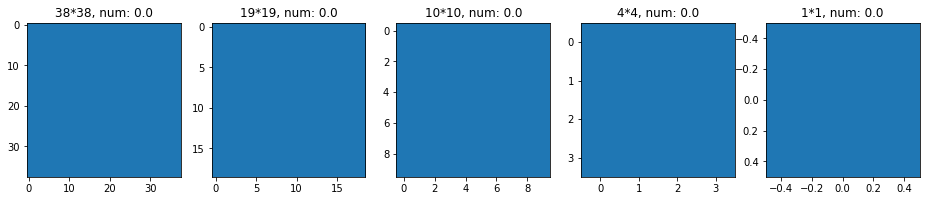

anchor index: 4


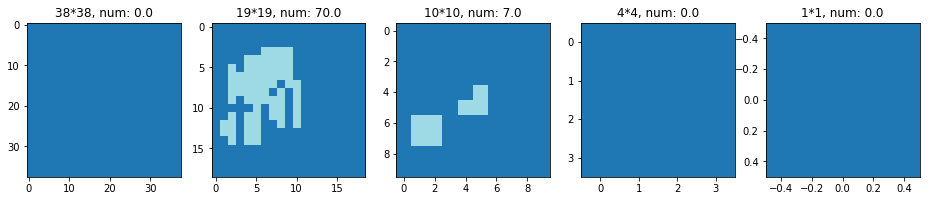

anchor index: 5


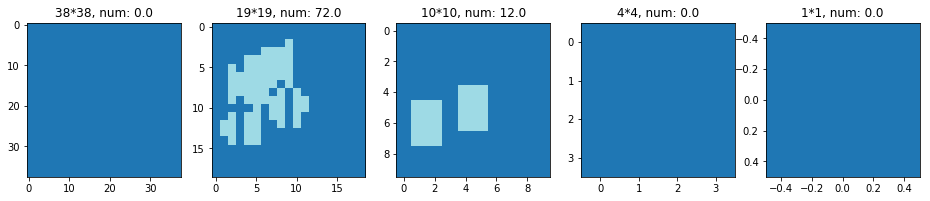

negative samples on each feature map:
anchor index: 0


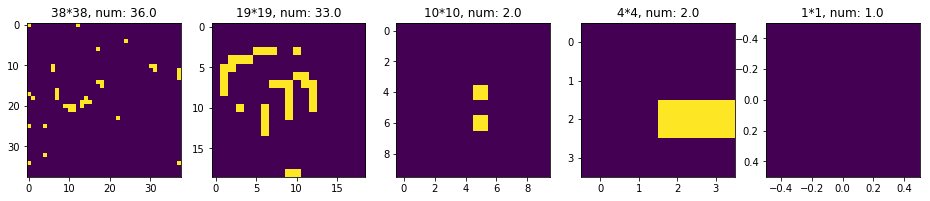

anchor index: 1


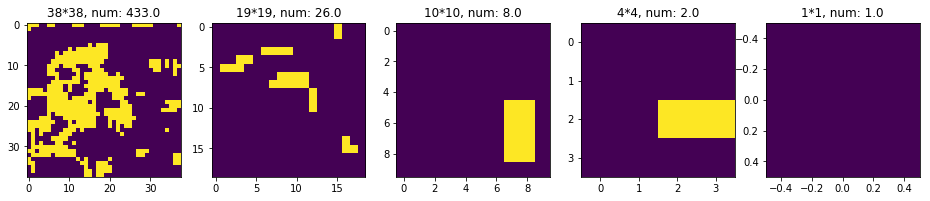

anchor index: 2


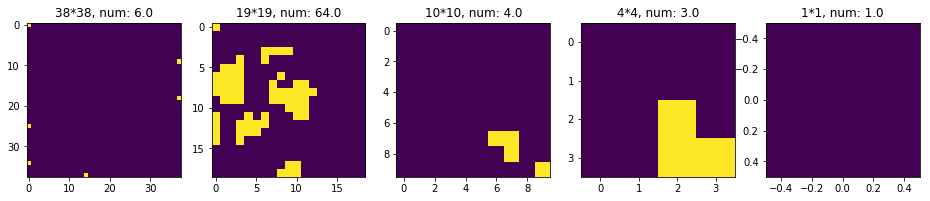

anchor index: 3


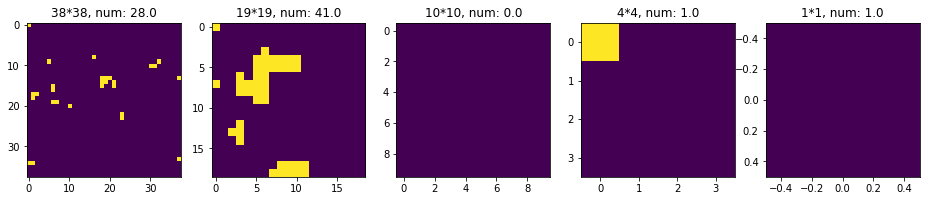

anchor index: 4


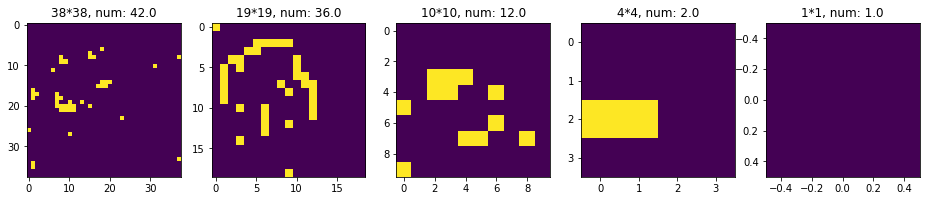

anchor index: 5


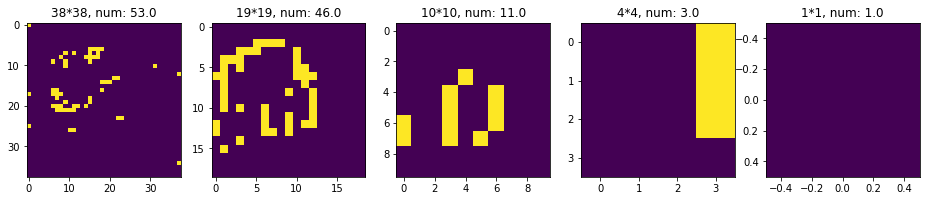

img 4: positives: 150.0, negatives: 450.0


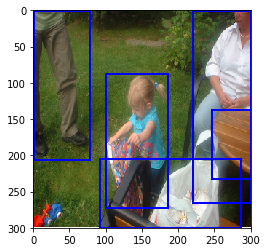

positive samples on each feature map:
anchor index: 0


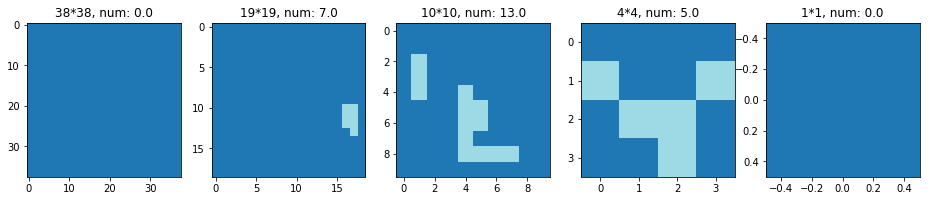

anchor index: 1


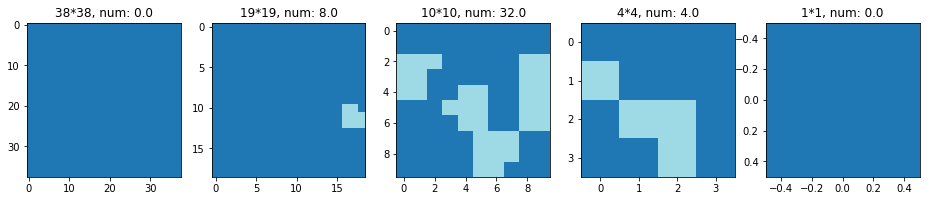

anchor index: 2


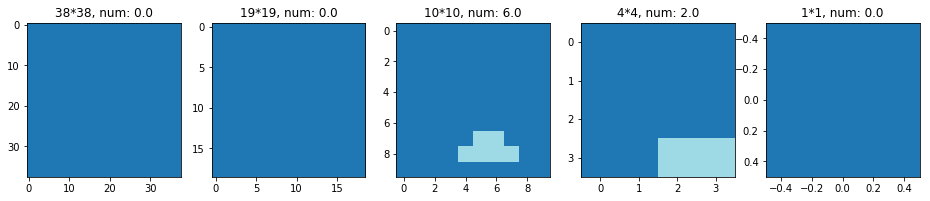

anchor index: 3


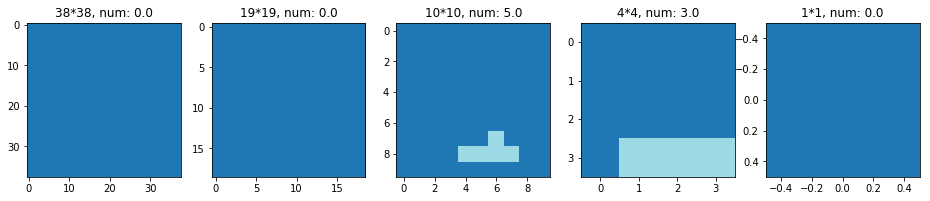

anchor index: 4


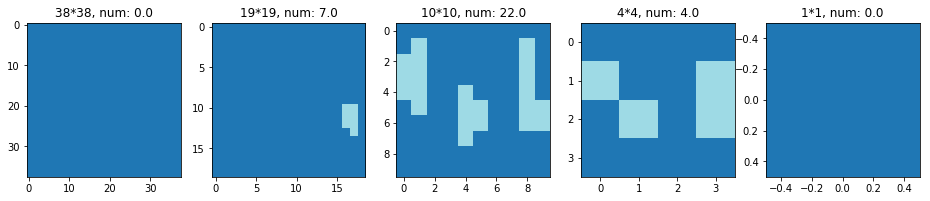

anchor index: 5


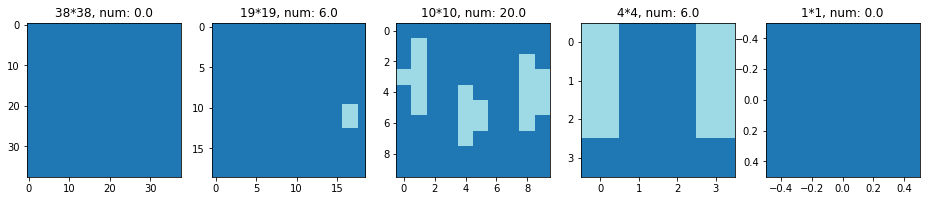

negative samples on each feature map:
anchor index: 0


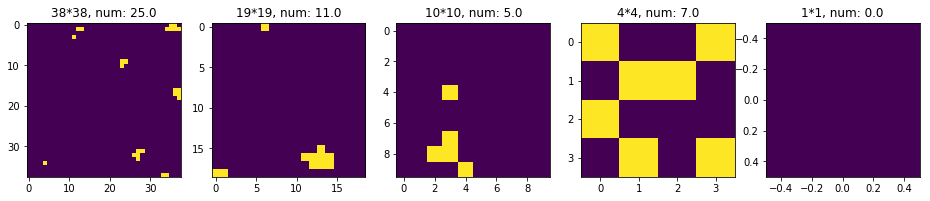

anchor index: 1


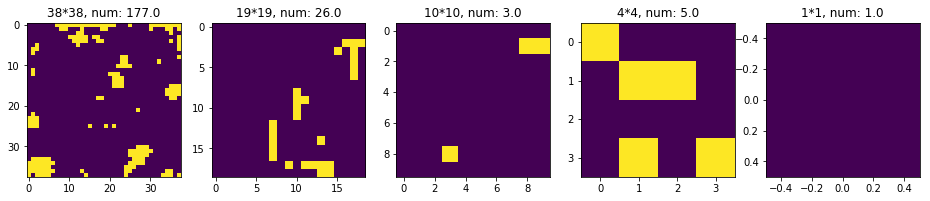

anchor index: 2


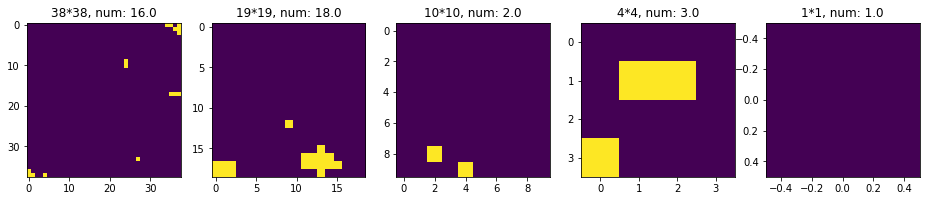

anchor index: 3


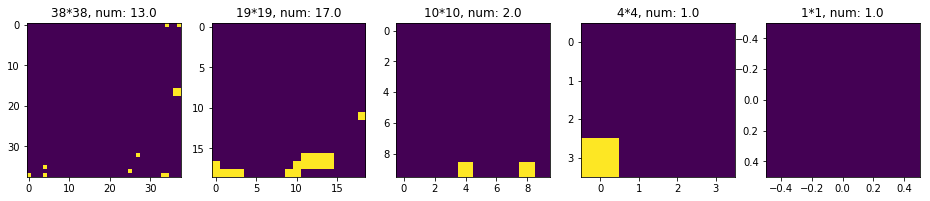

anchor index: 4


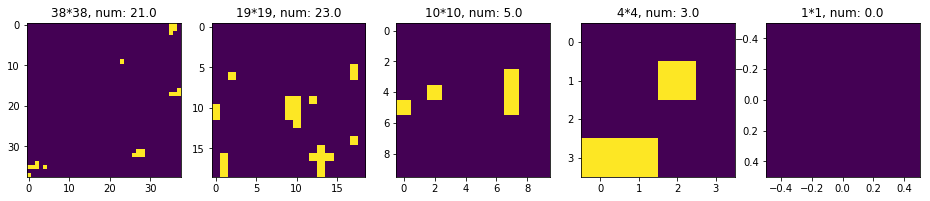

anchor index: 5


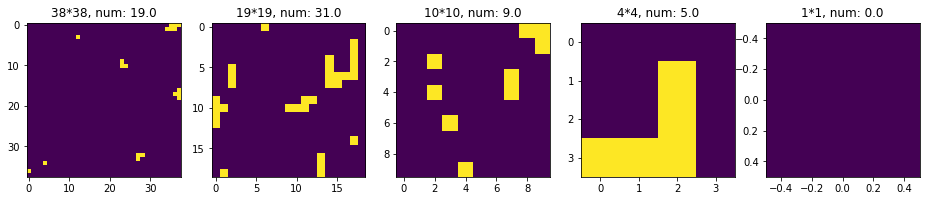

img 5: positives: 30.0, negatives: 90.0


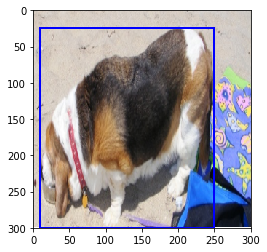

positive samples on each feature map:
anchor index: 0


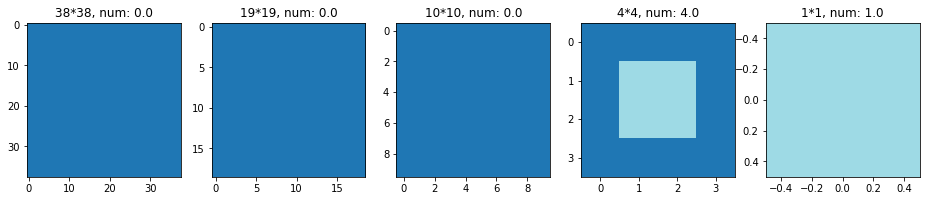

anchor index: 1


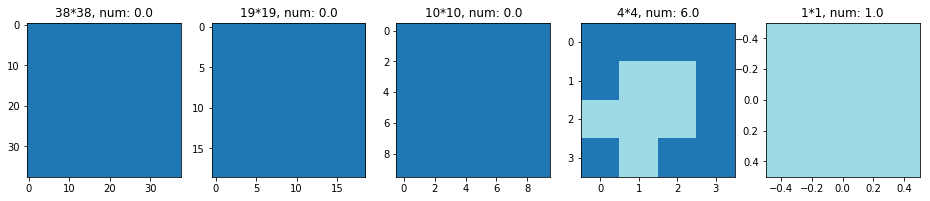

anchor index: 2


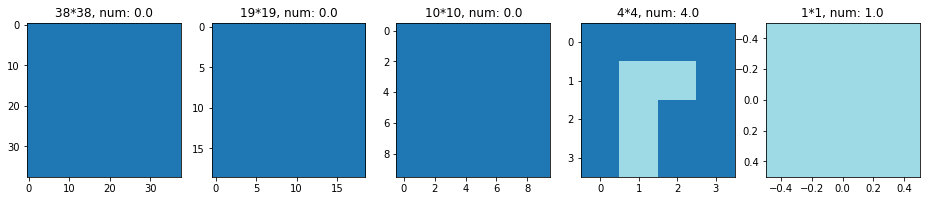

anchor index: 3


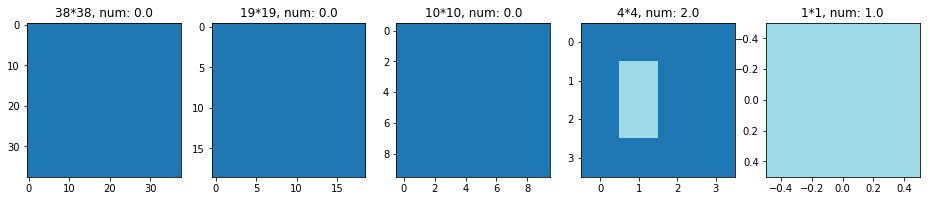

anchor index: 4


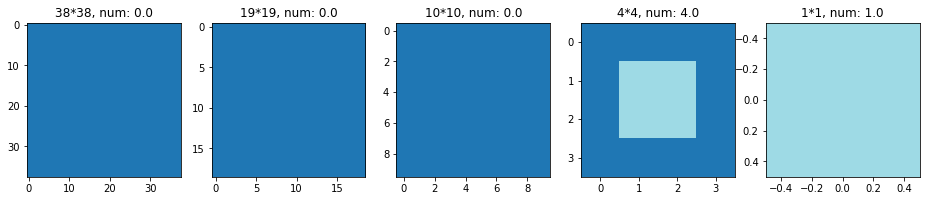

anchor index: 5


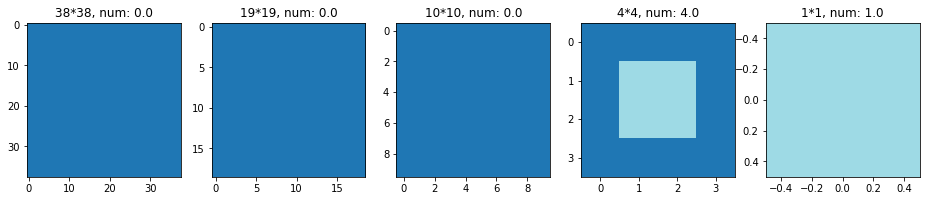

negative samples on each feature map:
anchor index: 0


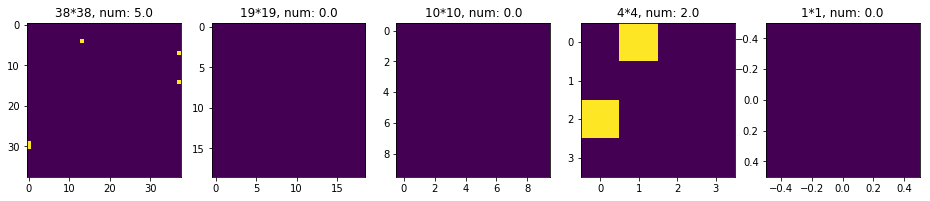

anchor index: 1


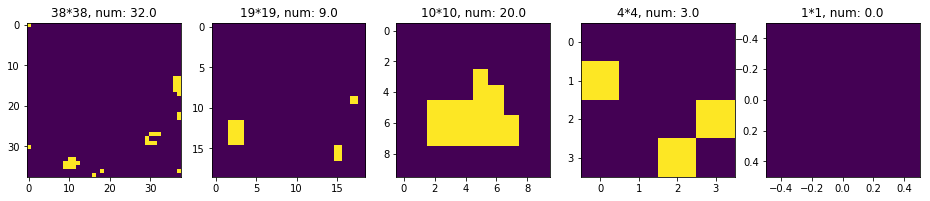

anchor index: 2


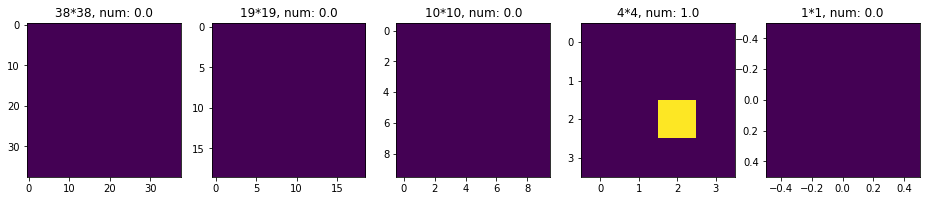

anchor index: 3


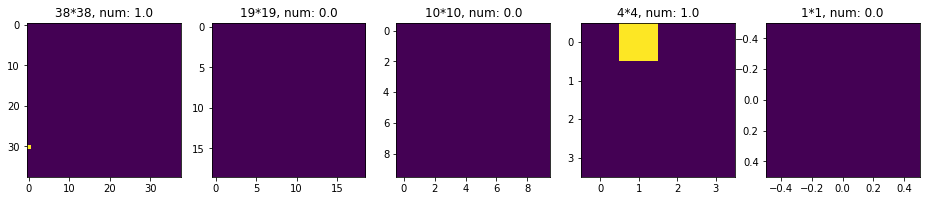

anchor index: 4


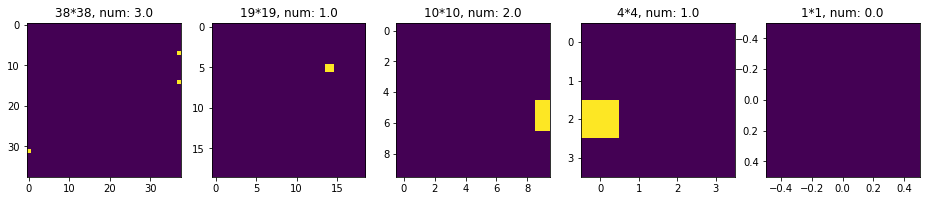

anchor index: 5


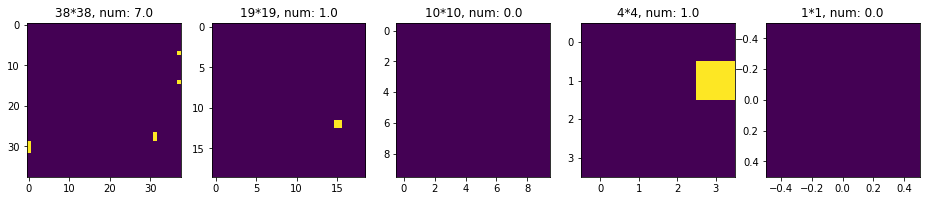

img 6: positives: 60.0, negatives: 180.0


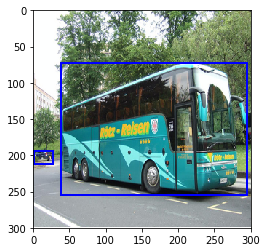

positive samples on each feature map:
anchor index: 0


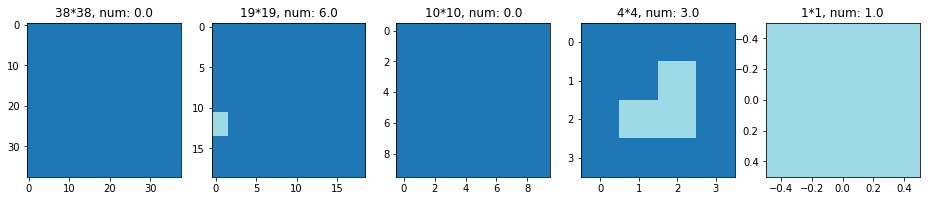

anchor index: 1


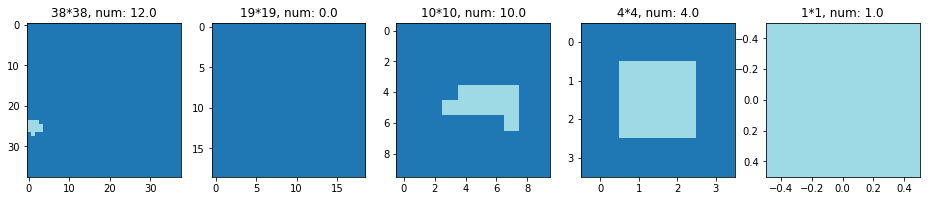

anchor index: 2


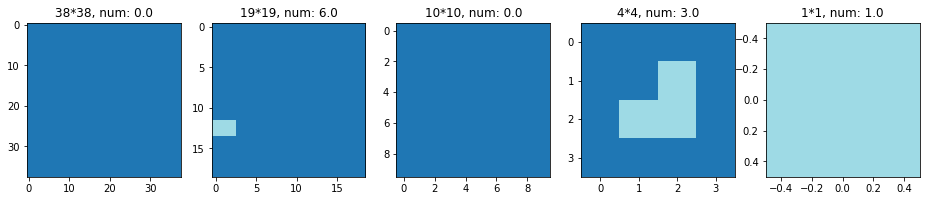

anchor index: 3


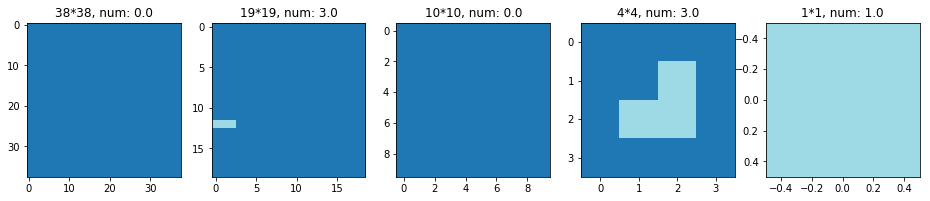

anchor index: 4


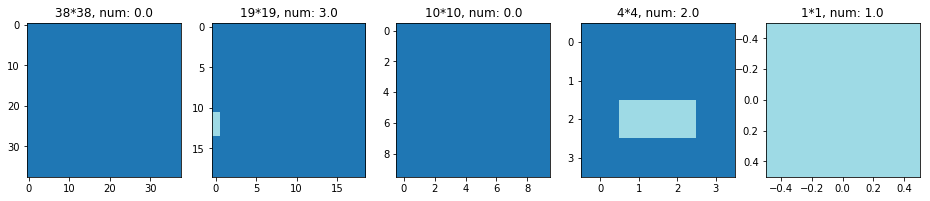

anchor index: 5


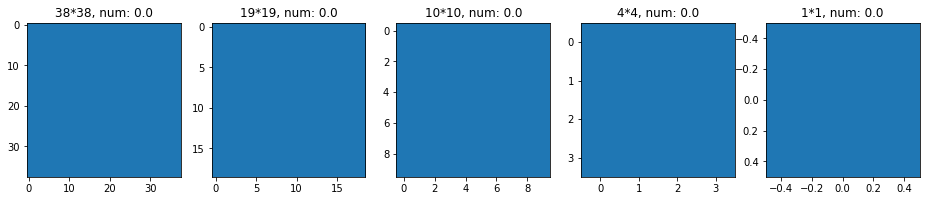

negative samples on each feature map:
anchor index: 0


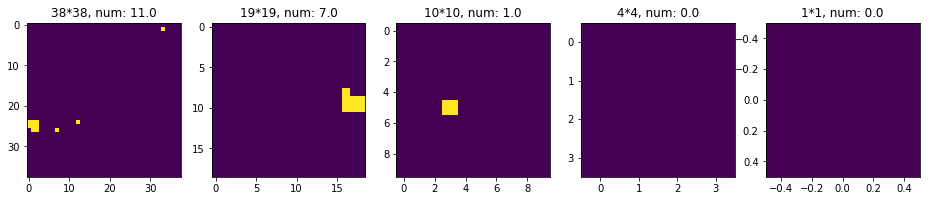

anchor index: 1


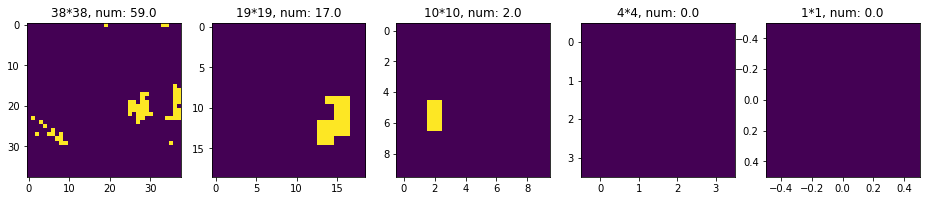

anchor index: 2


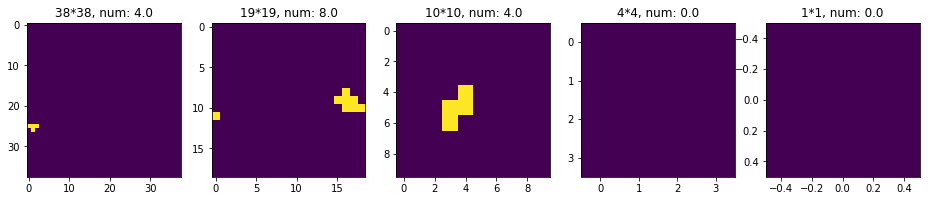

anchor index: 3


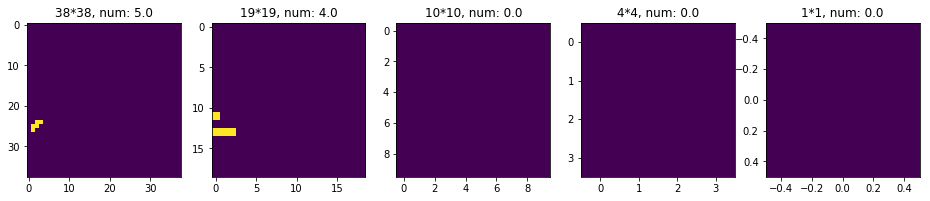

anchor index: 4


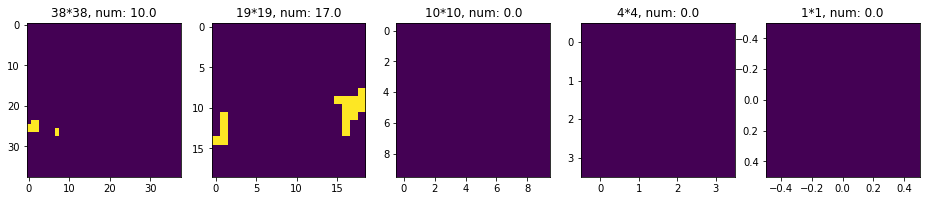

anchor index: 5


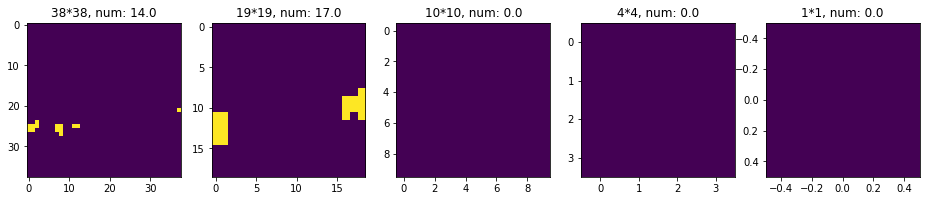

img 7: positives: 30.0, negatives: 90.0


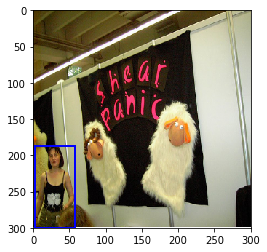

positive samples on each feature map:
anchor index: 0


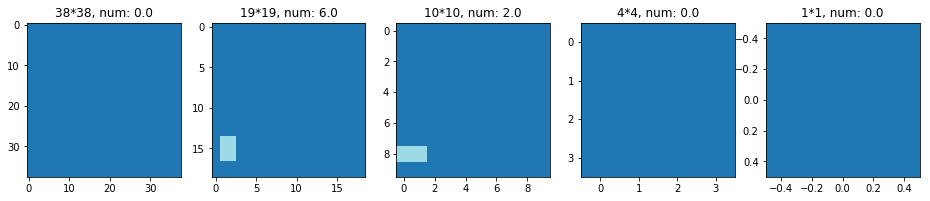

anchor index: 1


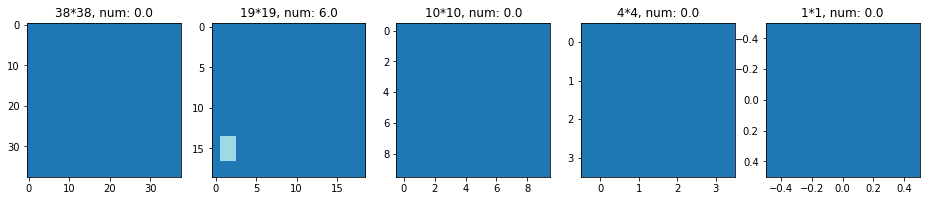

anchor index: 2


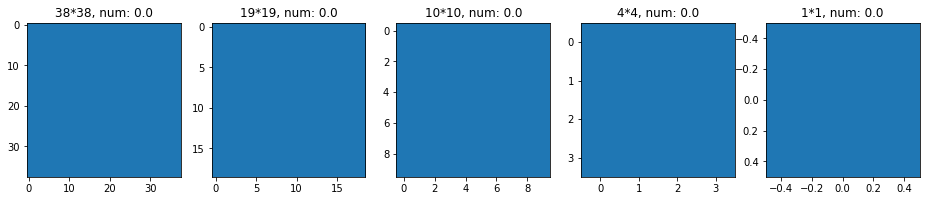

anchor index: 3


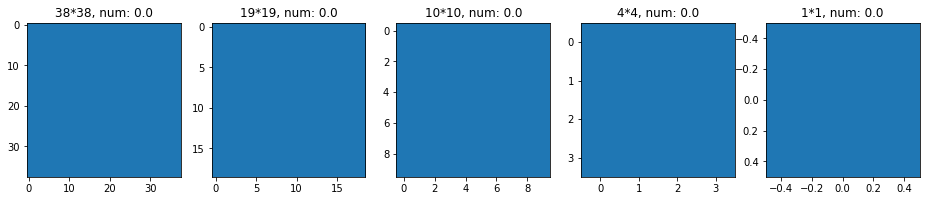

anchor index: 4


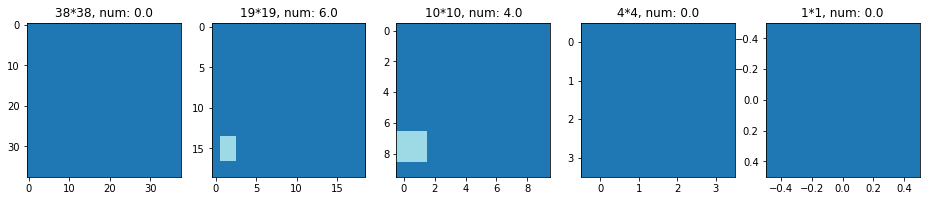

anchor index: 5


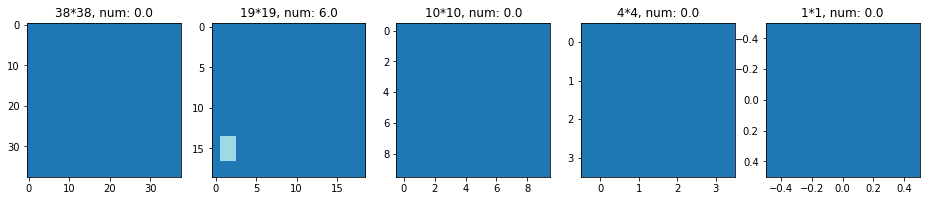

negative samples on each feature map:
anchor index: 0


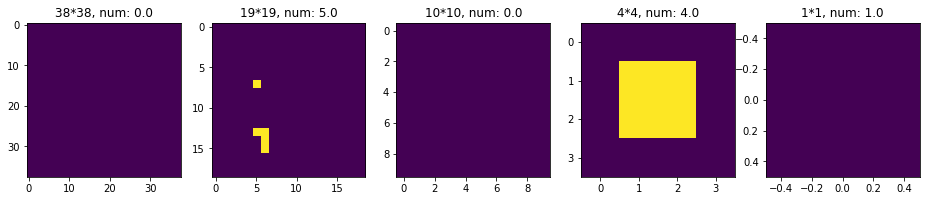

anchor index: 1


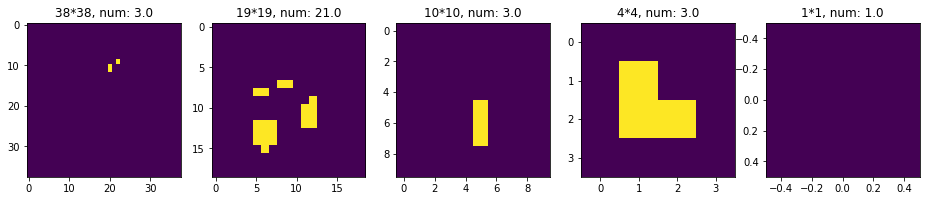

anchor index: 2


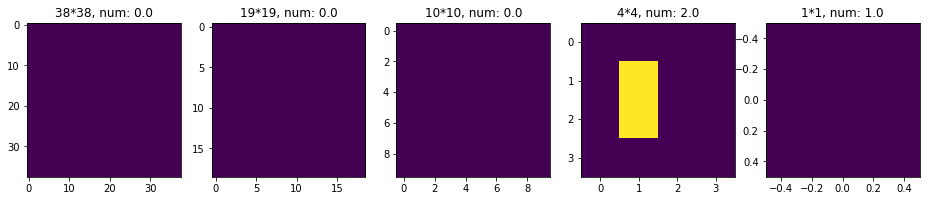

anchor index: 3


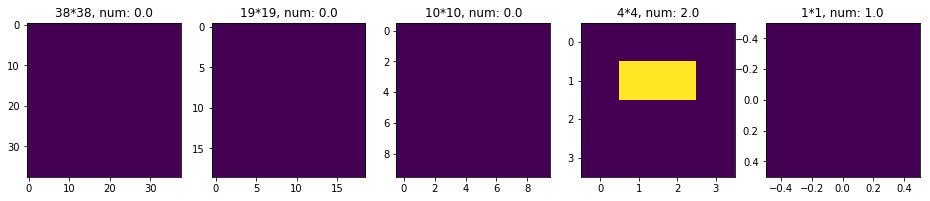

anchor index: 4


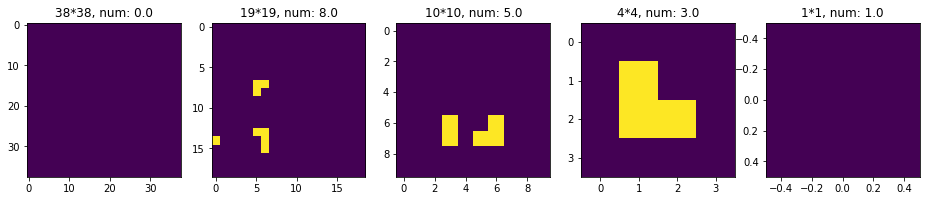

anchor index: 5


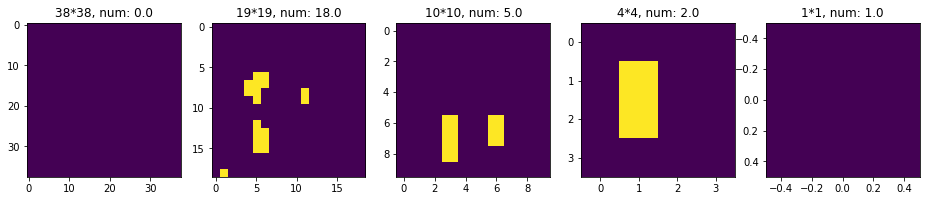

img 8: positives: 60.0, negatives: 180.0


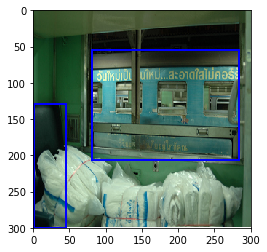

positive samples on each feature map:
anchor index: 0


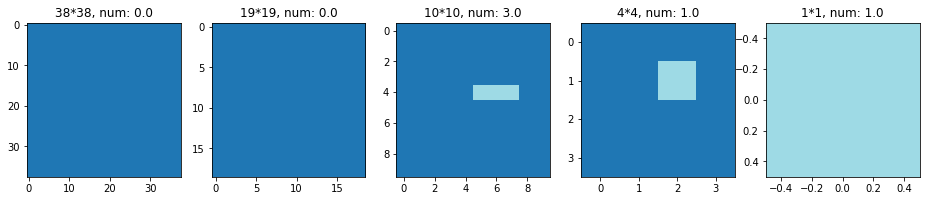

anchor index: 1


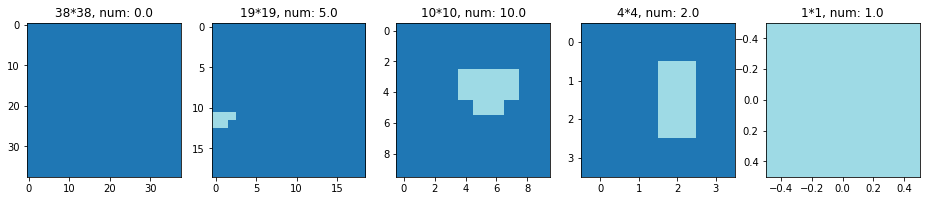

anchor index: 2


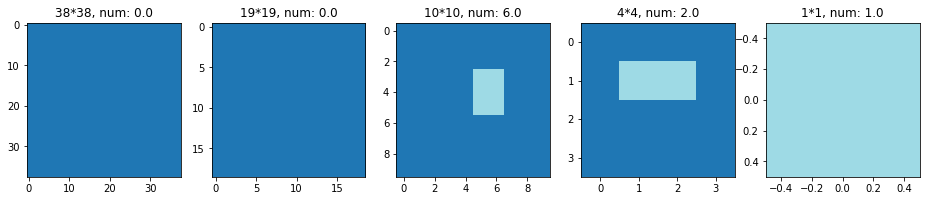

anchor index: 3


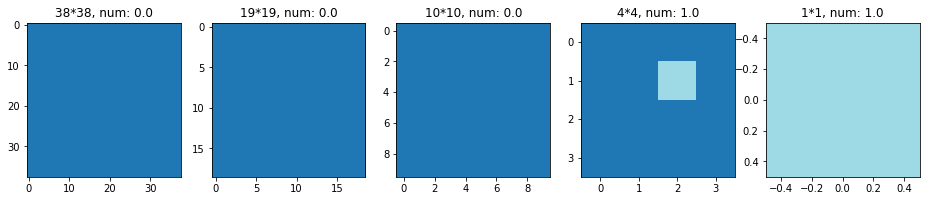

anchor index: 4


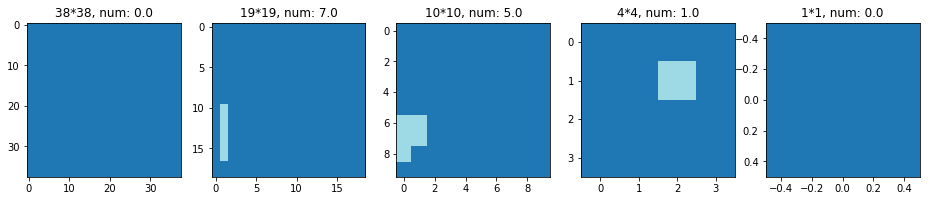

anchor index: 5


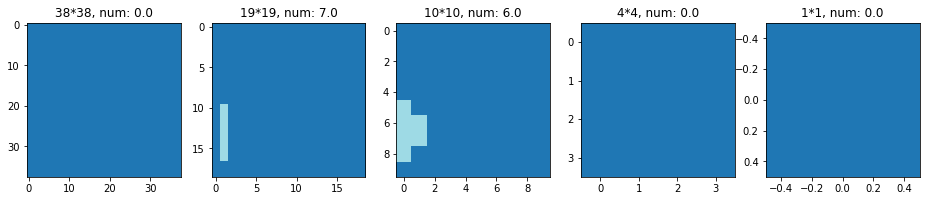

negative samples on each feature map:
anchor index: 0


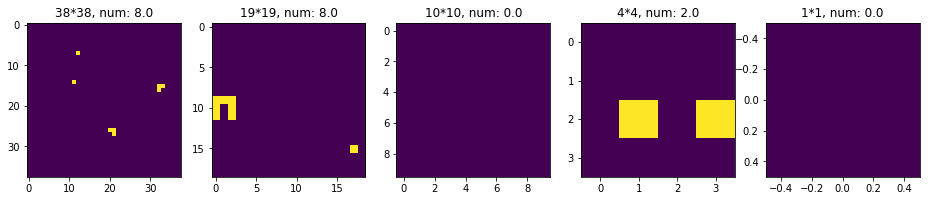

anchor index: 1


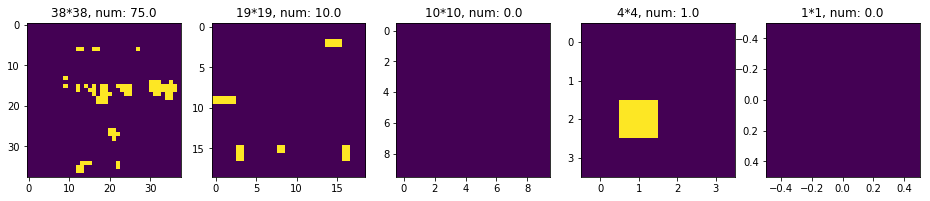

anchor index: 2


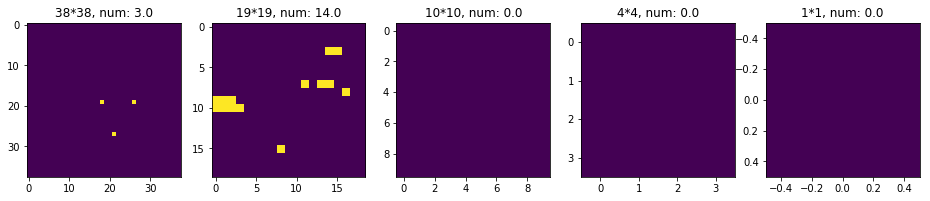

anchor index: 3


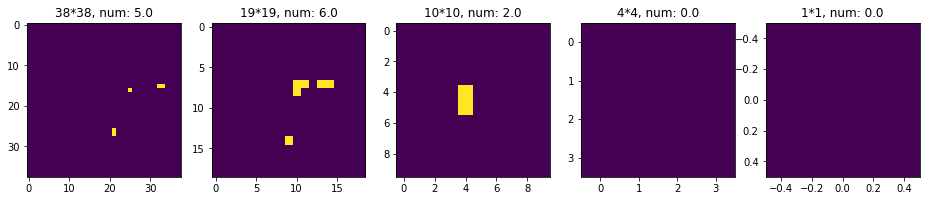

anchor index: 4


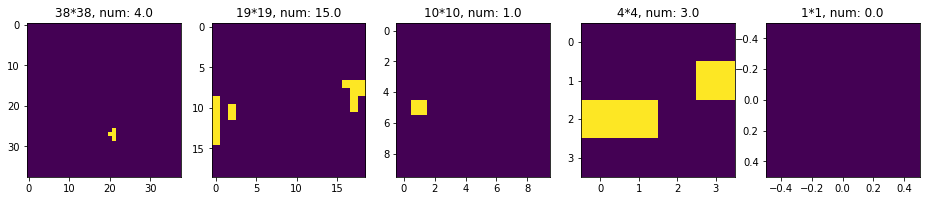

anchor index: 5


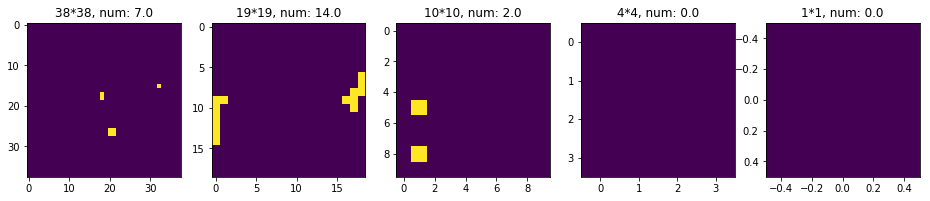

img 9: positives: 60.0, negatives: 180.0


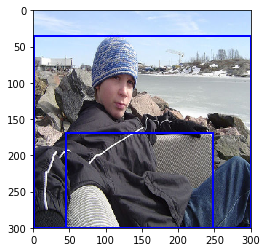

positive samples on each feature map:
anchor index: 0


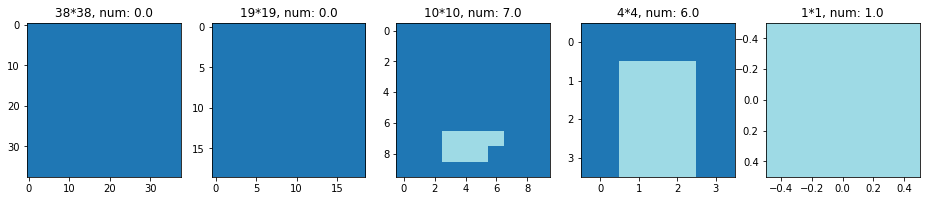

anchor index: 1


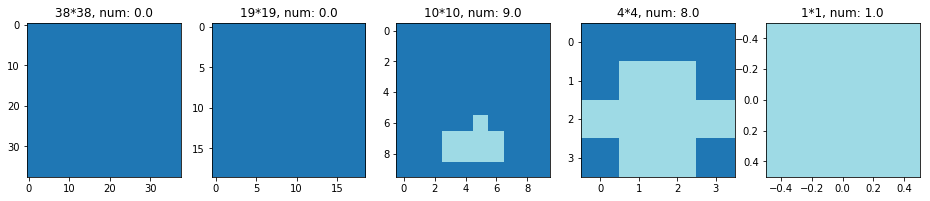

anchor index: 2


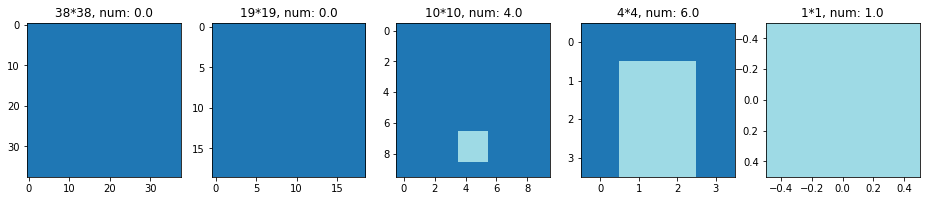

anchor index: 3


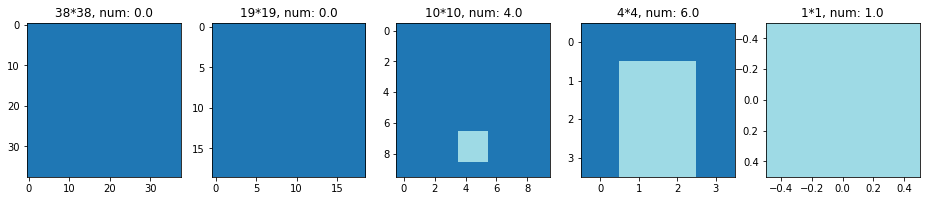

anchor index: 4


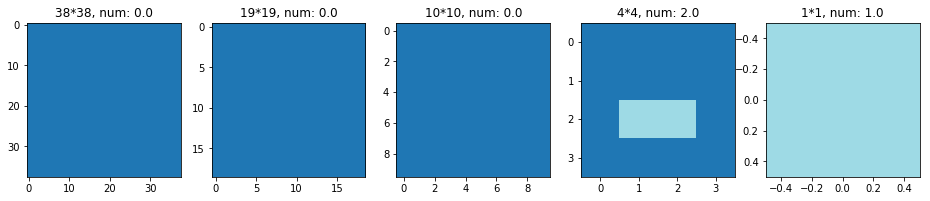

anchor index: 5


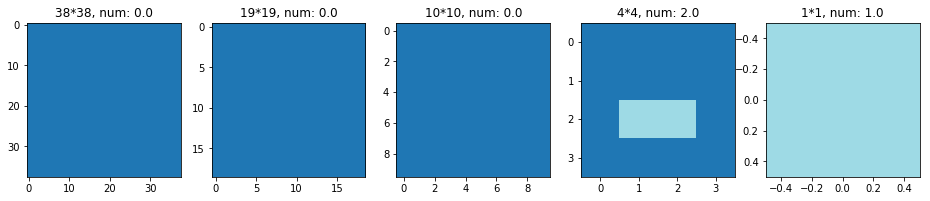

negative samples on each feature map:
anchor index: 0


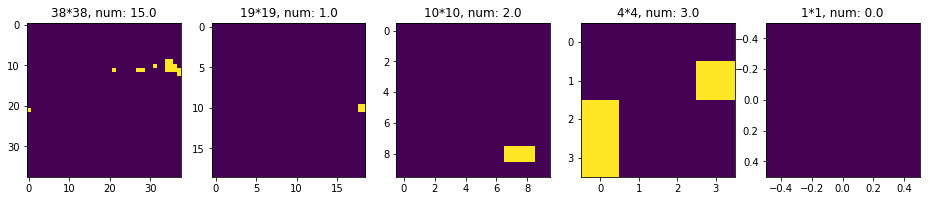

anchor index: 1


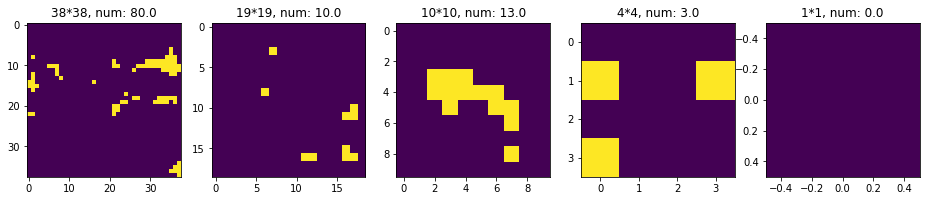

anchor index: 2


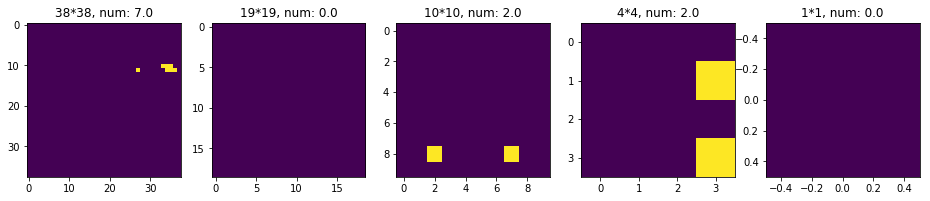

anchor index: 3


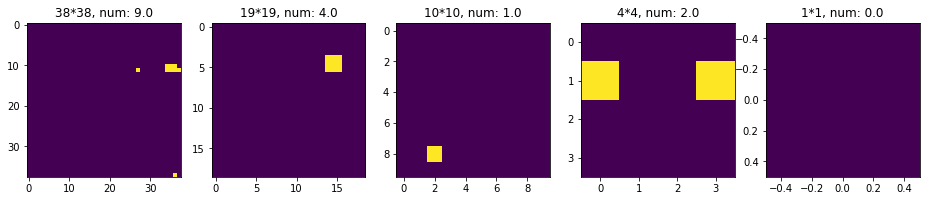

anchor index: 4


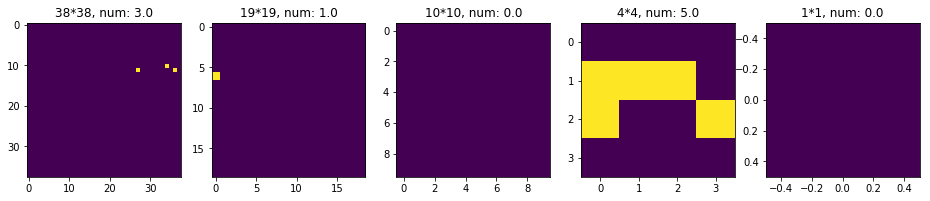

anchor index: 5


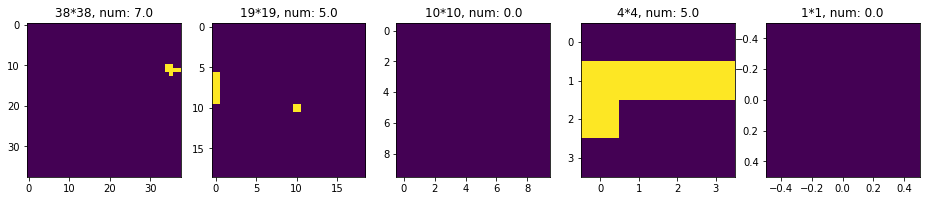

In [137]:
importlib.reload(ssd_utils_test)
importlib.reload(ssd_utils)
ssd_utils_test.test_generate_target2(mx_imgs, mx_labels, ssd, check_opt=['samples'])